# EV Charging Graph Model
### David Santiago Buitrago Prada
26/11/25

This notebook builds a Bogota city graph `G` and an aggregated antenna graph `Ga`,
computes AOC vs Dijkstra routes for a simulated fleet of vehicles,
measures execution times, and provides per-vehicle visualizations and Graph's analysis.

**Sections:**
- Setup & Graph Construction
- Graph Visualization
- Experiment: AOC vs Dijkstra
- Graph Analysis
- Results
- Conclusion


In [ ]:
pip install -r requirements.txt

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
# Improve default resolution for inline display
plt.rcParams['figure.dpi'] = 100
print('Matplotlib inline backend enabled')

Matplotlib inline backend enabled


---

# Graphs Overview

This notebook utilizes two primary graphs to model the city of Bogota and it's simulated charging infrastructure:

1. **City Graph (`G`)**:
    - Represents the city as a graph where nodes correspond to neighborhoods (e.g., Suba, Usaquen) and edges represent roads connecting them.
    - Each edge is weighted by the distance (in kilometers) between the connected neighborhoods.
    - The graph is constructed using the `NODES` and `EDGES` lists.

2. **Antenna Graph (`Ga`)**:
    - Represents an aggregated topology of charging stations (antennas) in the city.
    - Nodes correspond to antennas, and edges represent direct connections between them.
    - All edges are assigned a default weight of `GA_DEFAULT_WEIGHT`.

These graphs serve as the foundation for simulating electric vehicle routing, analyzing network centralities, and evaluating the integration of charging stations into the city's transportation network.

ev_model modules loaded


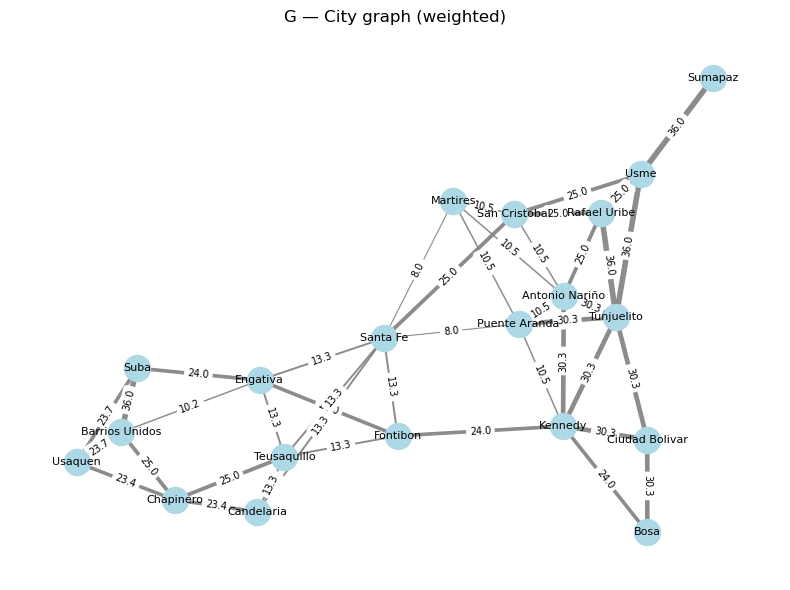

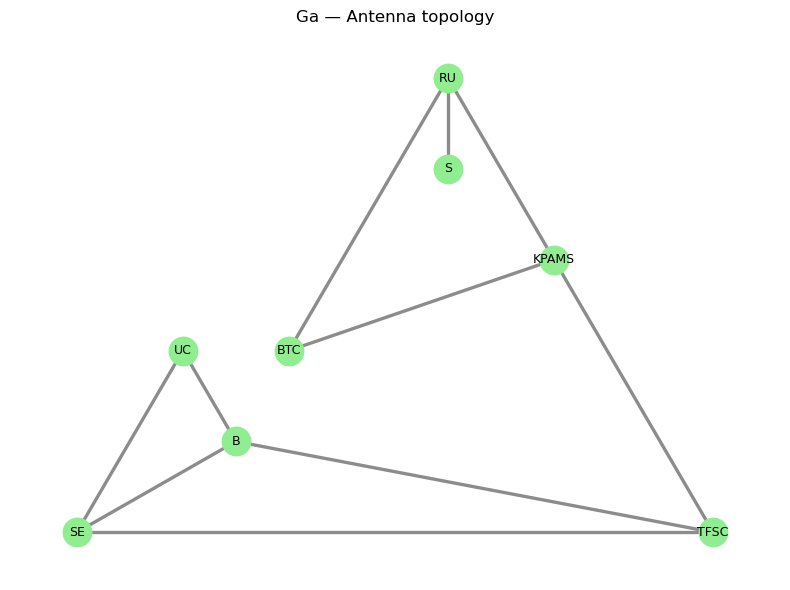

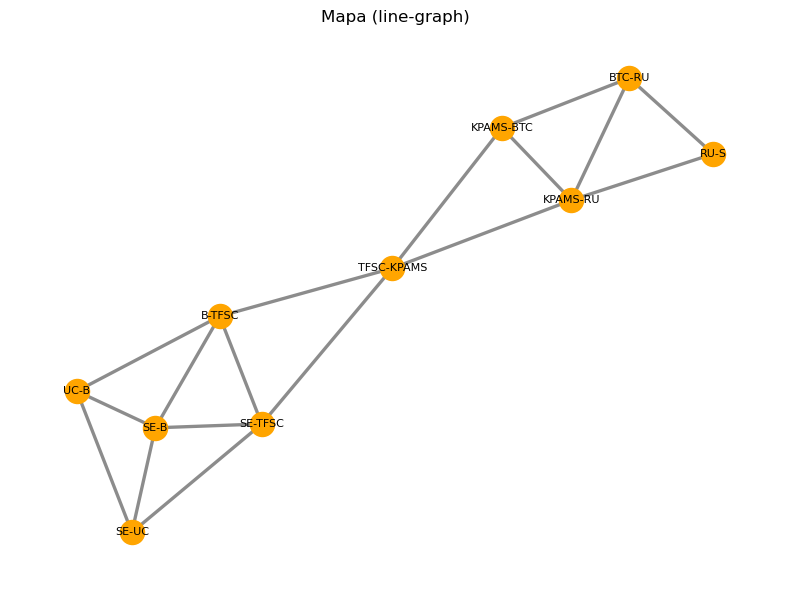

In [ ]:
from ev_model import graphs, simulation, utils, entities, viz
import networkx as nx
import matplotlib.pyplot as plt

print('ev_model modules loaded')
# --- Parameters ---
# You can edit the following lists to change the graphs used by the notebook.

NODES = [
    'Suba', 'Usaquen', 'Chapinero', 'Candelaria', 'Barrios Unidos',
    'Engativa', 'Fontibon', 'Teusaquillo', 'Martires', 'Santa Fe',
    'Usme', 'San Cristobal', 'Antonio Nariño', 'Puente Aranda',
    'Kennedy', 'Bosa', 'Rafael Uribe', 'Tunjuelito', 'Ciudad Bolivar',
    'Sumapaz'
]
# edges: tuples (u, v, weight)
EDGES = [
    ('Suba', 'Usaquen', 23.7), # autonorte
    ('Barrios Unidos', 'Usaquen', 23.7), # autonorte
    ('Usaquen', 'Chapinero', 23.4), # 7ma
    ('Chapinero', 'Candelaria', 23.4), # 7ma
    ('Chapinero', 'Barrios Unidos', 25), # Caracas
    ('Chapinero', 'Teusaquillo', 25), # Caracas
    ('Santa Fe', 'San Cristobal', 25), # Caracas
    ('San Cristobal', 'Rafael Uribe', 25), # Caracas
    ('San Cristobal', 'Usme', 25), # Caracas
    ('Usme', 'Rafael Uribe', 25), # Caracas
    ('Antonio Nariño', 'Rafael Uribe', 25), # Caracas
    ('Santa Fe', 'Martires', 8), # Americas
    ('Santa Fe', 'Puente Aranda', 8), # Americas
    ('Engativa', 'Barrios Unidos', 10.2), # ac 80
    ('Engativa', 'Teusaquillo', 13.3), # ac 26
    ('Candelaria', 'Teusaquillo', 13.3), # ac 26
    ('Santa Fe', 'Teusaquillo', 13.3), # ac 26
    ('Candelaria', 'Santa Fe', 13.3), # ac 26
    ('Engativa', 'Santa Fe', 13.3), # ac 26
    ('Fontibon', 'Santa Fe', 13.3), # ac 26
    ('Fontibon', 'Teusaquillo', 13.3), # ac 26
    ('Suba', 'Barrios Unidos', 36), # av Boyaca
    ('Usme', 'Sumapaz', 36), # av Boyaca
    ('Rafael Uribe', 'Tunjuelito', 36), # av Boyaca
    ('Usme', 'Tunjuelito', 36), # av Boyoca
    ('Suba', 'Engativa', 24), # av cali
    ('Fontibon', 'Engativa', 24), # av cali
    ('Fontibon', 'Kennedy', 24), # av cali
    ('Kennedy', 'Bosa', 24), # av cali
    ('Puente Aranda', 'Kennedy', 10.5), # av 1ra de mayo
    ('Puente Aranda', 'Antonio Nariño', 10.5), # av 1ra de mayo
    ('Puente Aranda', 'Martires', 10.5), # av 1ra de mayo
    ('Antonio Nariño', 'San Cristobal', 10.5), # av 1ra de mayo
    ('Martires', 'San Cristobal', 10.5), # av 1ra de mayo
    ('Martires', 'Antonio Nariño', 10.5), # av 1ra de mayo
    ('Kennedy', 'Tunjuelito', 30.3), # autosur
    ('Kennedy', 'Ciudad Bolivar', 30.3), # autosur
    ('Bosa', 'Ciudad Bolivar', 30.3), # autosur
    ('Tunjuelito', 'Ciudad Bolivar', 30.3), # autosur
    ('Tunjuelito', 'Antonio Nariño', 30.3), # autosur
    ('Tunjuelito', 'Puente Aranda', 30.3), # autosur
    ('Kennedy', 'Antonio Nariño', 30.3) # autosur
]
# Build G from the notebook-specified lists
G = nx.Graph()
G.add_nodes_from(NODES)
G.add_weighted_edges_from(EDGES)

# Aggregated graph (Ga) parameters - also editable in the notebook
GA_NODES = ['SE','UC','B','TFSC','KPAMS','BTC','RU','S']
GA_EDGES = [('SE','TFSC'),('SE','UC'),('TFSC','KPAMS'),('KPAMS','BTC'),('KPAMS','RU'),('BTC','RU'),('RU','S'),('B','SE'),('B','TFSC'),('B','UC')]
GA_DEFAULT_WEIGHT = 1.0
Ga = nx.Graph()
Ga.add_nodes_from(GA_NODES)
Ga.add_edges_from(GA_EDGES)
for u,v in Ga.edges():
    Ga[u][v]['weight'] = GA_DEFAULT_WEIGHT

mapa = graphs.build_mapa(Ga)

viz.draw_graph(G, layout='spring', show_edge_weights=True, weight_attr='weight', scale_width=(0.8, 4.0),
               node_color='lightblue', node_size=350, font_size=8, seed=42, title='G — City graph (weighted)')

viz.draw_graph(Ga, layout='planar', show_edge_weights=False, node_color='lightgreen', node_size=420,
               font_size=9, seed=24, title='Ga — Antenna topology')

# Optionally: visualize the mapa (line-graph) if available
if 'mapa' in globals():
    try:
        from ev_model import viz
    except Exception as e:
        print("Could not import ev_model.viz:", e)
    else:
        viz.draw_graph(mapa, layout='spring', node_color='orange', node_size=300, title='Mapa (line-graph)')

---

## Dijkstra and AOC Algorithms

### Dijkstra's Algorithm
Dijkstra's algorithm is a classic graph traversal algorithm used to find the shortest path between nodes in a graph. It operates by iteratively selecting the node with the smallest tentative distance, updating the distances of its neighbors, and marking it as visited. This process continues until the shortest path to the target node is determined. Dijkstra's algorithm is widely used in network routing, navigation systems, and other applications requiring optimal pathfinding.

### Ant Colony Optimization (AOC)
Ant Colony Optimization (AOC) is a nature-inspired metaheuristic algorithm that mimics the behavior of ants searching for food. In AOC, artificial ants traverse a graph, depositing pheromones on paths they take. Over time, paths with higher pheromone levels attract more ants, reinforcing optimal routes. AOC is particularly effective for solving combinatorial optimization problems, such as the traveling salesman problem and vehicle routing.

### Application in This Context
In the context of this notebook, Dijkstra's algorithm and AOC are applied to simulate the routing of a fleet of electric vehicles (EVs) navigating through a city graph (`G`). The goal is to compute routes to the nearest charging stations, represented in an aggregated antenna graph (`Ga`). By comparing the routes generated by Dijkstra's algorithm and AOC, we aim to evaluate their efficiency, execution time, and suitability for EV routing. This analysis provides insights into the trade-offs between deterministic and heuristic approaches in real-world transportation networks.

---

## Experiment: AOC vs Dijkstra Routing and Performance Analysis

This experiment aims to evaluate and compare the performance of two routing algorithms, **AOC (Ant Colony Optimization)** and **Dijkstra's Algorithm**, in the context of a simulated fleet of electric vehicles navigating through the city graph `G`. The experiment is designed to measure the efficiency, execution time, and route characteristics of each algorithm under various conditions.

## Objectives:
1. **Route Comparison**: Analyze the routes generated by AOC and Dijkstra for each vehicle in the fleet, comparing their lengths and the nodes visited.
2. **Performance Metrics**: Measure the execution time of both algorithms to evaluate their computational efficiency.
3. **Integration with Antennas**: Assess the integration of the city graph `G` with the aggregated antenna graph `Ga`, and determine the nearest antenna for each vehicle's starting location.
4. **Visualization**: Provide interactive visualizations of the routes for individual vehicles, highlighting the differences between AOC and Dijkstra.

## Methodology:
- A fleet of `n=1000` vehicles is simulated, each with a random starting location and battery level.
- The city graph `G` is used to compute routes, while the antenna graph `Ga` is used to determine the nearest antenna for each node.
- For each vehicle:
    - The AOC algorithm is executed `n_trials=50` times to compute an optimal route to the nearest charging station.
    - Dijkstra's algorithm is used to compute the shortest path to the nearest charging station.
    - The execution time and route length for both algorithms are recorded.
- The results are stored in a DataFrame and exported as a CSV file for further analysis.

## Outputs:
- **Route Data**: A detailed DataFrame containing the routes, execution times, and other metrics for each vehicle.
- **Visualization**: Interactive widgets to explore the routes of individual vehicles, along with static visualizations for environments without widget support.
- **CSV Export**: The results are saved as a CSV file for reproducibility and further analysis.

In [ ]:
# Experiment: compute AOC and Dijkstra routes, measure times and visualize per-vehicle with a slider
from ev_model import simulation, viz
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import time
try:
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    WIDGETS_AVAILABLE = True
except Exception:
    WIDGETS_AVAILABLE = False

# Experiment parameters
n = 1000  # number of vehicles
seed = 123
n_trials = 50  # AOC trials

ubicaciones = {
    'SE': ('Suba',),
    'UC': ('Usaquen',),
    'B': ('Chapinero',),
    'TFSC': ('Teusaquillo',),
    'KPAMS': ('Santa Fe',),
    'BTC': ('Fontibon',),
    'RU': ('Rafael Uribe',),
    'S': ('Sumapaz',),
}

# Run the simulation without computing routes (we compute routes here to measure timings)
res = simulation.run_example(n=n, G=G, Ga=Ga, ubicaciones=ubicaciones, random_seed=seed, compute_routes=False)
flota = res['flota'].total
estaciones = res['estaciones']
G = res['G']

# Collect routes and timings per vehicle
rows = []
for auto in flota:
    placa = auto.placa
    ubic = auto.ubicacion
    bateria = auto.bateria

    # AOC (measure time)
    t0 = time.perf_counter()
    try:
        aoc_route = auto.AOC(n_trials, estaciones, G=G)
    except Exception:
        aoc_route = [ubic]
    aoc_time = time.perf_counter() - t0

    # Dijkstra (method supports measure_time)
    try:
        dres = auto.route_dijkstra(estaciones, G=G, measure_time=True)
        if isinstance(dres, tuple):
            dijkstra_route, dijkstra_time = dres
        else:
            dijkstra_route, dijkstra_time = dres, 0.0
    except Exception:
        dijkstra_route, dijkstra_time = [ubic], 0.0

    rows.append({
        'placa': placa,
        'ubicacion': ubic,
        'bateria': bateria,
        'aoc_route': aoc_route,
        'aoc_time': aoc_time,
        'dijkstra_route': dijkstra_route,
        'dijkstra_time': dijkstra_time,
        'aoc_route_len': max(0, len(aoc_route)-1) if isinstance(aoc_route, (list,tuple)) else 0,
        'dijkstra_route_len': max(0, len(dijkstra_route)-1) if isinstance(dijkstra_route, (list,tuple)) else 0,
    })

# Antenna integration: use routing helper to annotate rows
from ev_model.entities import Antenas
from ev_model.routing import integrate_antennas
antenas_obj = Antenas(Ga)
rep_map, rep_to_ga, distances, paths = integrate_antennas(rows, G, antenas_obj, ubicaciones)

import os
os.makedirs('outputs', exist_ok=True)
df = pd.DataFrame(rows)
csv_path = os.path.join('outputs', 'results_routes.csv')
df.to_csv(csv_path, index=False)
print(f'Saved single results CSV to: {csv_path}')
display(df[[ 'placa','ubicacion','nearest_antena','dist_to_antena','dijkstra_route','aoc_time','dijkstra_time' ]])

# Prepare positions for drawing (use helper in ev_model.viz)
pos = viz.get_positions(G, seed=42)

# Display using helpers in ev_model.viz
if WIDGETS_AVAILABLE and len(rows) > 0:
    slider = widgets.IntSlider(min=0, max=len(rows)-1, step=1, value=0, description='Vehicle')
    out = widgets.interactive_output(lambda idx: viz.draw_vehicle_by_index(G, rows, estaciones, rep_map, rep_to_ga, idx, pos), {'idx': slider})
    display(widgets.HBox([slider]))
    display(out)
else:
    print('ipywidgets not available: showing the first static visualization.')
    viz.draw_vehicle_by_index(G, rows, estaciones, rep_map, rep_to_ga, 0, pos)

Saved single results CSV to: outputs\results_routes.csv


,placa,ubicacion,nearest_antena,dist_to_antena,dijkstra_route,aoc_time,dijkstra_time
0,car0,Kennedy,KPAMS,18.5,"[Kennedy, Puente Aranda, Santa Fe]",0.000477,0.000207
1,car1,San Cristobal,KPAMS,18.5,"[San Cristobal, Martires, Santa Fe]",0.000268,0.000094
2,car2,Engativa,TFSC,13.3,"[Engativa, Teusaquillo]",0.000098,0.000068
3,car3,San Cristobal,KPAMS,18.5,"[San Cristobal, Martires, Santa Fe]",0.000218,0.000070
4,car4,San Cristobal,KPAMS,18.5,"[San Cristobal, Martires, Santa Fe]",0.000197,0.000066
...,...,...,...,...,...,...,...
995,car995,Candelaria,TFSC,13.3,"[Candelaria, Teusaquillo]",0.000074,0.000049
996,car996,Kennedy,KPAMS,18.5,"[Kennedy, Puente Aranda, Santa Fe]",0.000247,0.000060
997,car997,Antonio Nariño,KPAMS,18.5,"[Antonio Nariño, Martires, Santa Fe]",0.000232,0.000061
998,car998,Barrios Unidos,TFSC,23.5,"[Barrios Unidos, Engativa, Teusaquillo]",0.000086,0.000057


Output()

In [ ]:
# Export interactive widget to outputs using ev_model.viz helper
try:
    from ev_model import viz
    if 'out' in globals():
        path = viz.export_widget(out, 'outputs/route_widget.html')
        print(f'Saved widget to: {path}')
    else:
        print("Widget 'out' not found. Execute the interactive cell that creates 'out' before exporting.")
except Exception as e:
    print('Could not export widget via viz.export_widget:', e)

---

# Centralities, Service Areas, and Critical Structures

In this section, a detailed analysis of the graph `G` is performed to evaluate its structure and key characteristics. This analysis includes:

1. **Centralities**: Metrics such as degree, betweenness, closeness, eigenvector, and PageRank centralities are calculated to identify the most important nodes in the network.
2. **Service Areas**: The coverage areas of the nearest antennas for each node are determined, evaluating the minimum distances and connections to the antennas.
3. **Critical Structures**: Articulation points and bridges in the graph are identified, which are essential for the network's connectivity.

The results of this analysis provide valuable insights into the network's topology, helping to identify key nodes and connections, as well as potential structural vulnerabilities.

Saved centralities to outputs/analysis/centralities.csv


,node,degree,betweenness,closeness,eigenvector,pagerank
9,Santa Fe,0.368421,0.508772,0.033599,0.085120,0.054687
13,Puente Aranda,0.263158,0.327485,0.032122,0.218237,0.038523
5,Engativa,0.263158,0.263158,0.027362,0.037606,0.050008
8,Martires,0.210526,0.248538,0.031561,0.076569,0.025694
11,San Cristobal,0.263158,0.184211,0.026874,0.202442,0.051977
14,Kennedy,0.315789,0.175439,0.026382,0.376532,0.074645
10,Usme,0.210526,0.105263,0.018416,0.315496,0.064380
4,Barrios Unidos,0.210526,0.093567,0.022695,0.012085,0.055976
12,Antonio Nariño,0.315789,0.093567,0.028127,0.358816,0.058887
3,Candelaria,0.157895,0.070175,0.025289,0.016102,0.032886


Saved service areas to outputs/analysis/service_areas.csv


,node,nearest_antena,dist_to_antena
0,Suba,SE,0.0
1,Usaquen,UC,0.0
2,Chapinero,B,0.0
3,Candelaria,TFSC,13.3
4,Barrios Unidos,TFSC,23.5
5,Engativa,TFSC,13.3
6,Fontibon,BTC,0.0
7,Teusaquillo,TFSC,0.0
8,Martires,KPAMS,8.0
9,Santa Fe,KPAMS,0.0


Saved critical structures to outputs/analysis/
Articulation points: 1, Bridges: 1


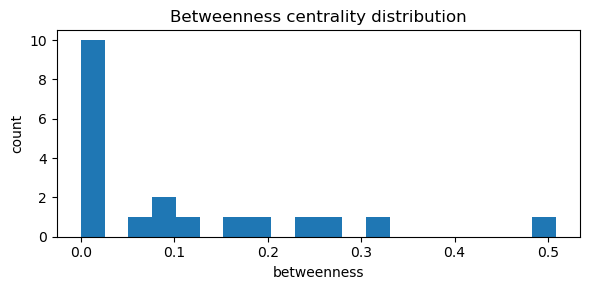

In [ ]:
# Análisis: centralities, service areas y estructuras críticas
from ev_model import analysis
from IPython.display import display
import os
import pandas as pd
import matplotlib.pyplot as plt

os.makedirs('outputs/analysis', exist_ok=True)

if 'G' not in globals():
    print('Graph `G` not found in the notebook namespace. Ejecuta la celda de construcción de grafos antes de ejecutar este análisis.')
else:
    # 1) Centralities
    try:
        centrals = analysis.compute_centralities(G)
        df_c = analysis.centralities_to_dataframe(centrals)
        df_c.to_csv('outputs/analysis/centralities.csv', index=False)
        print('Saved centralities to outputs/analysis/centralities.csv')
        display(df_c.sort_values(by='betweenness', ascending=False).head(10))
    except Exception as e:
        print('Error computing centralities:', e)

    # 2) Service areas (nearest antenna)
    try:
        if 'rep_map' in globals():
            distances, paths, nearest_map = analysis.service_areas(G, rep_map)
            df_sa = pd.DataFrame([
                {'node': n, 'nearest_antena': nearest_map.get(n), 'dist_to_antena': distances.get(n, float('inf'))}
                for n in G.nodes()
            ])
            df_sa.to_csv('outputs/analysis/service_areas.csv', index=False)
            print('Saved service areas to outputs/analysis/service_areas.csv')
            display(df_sa.head(10))
        else:
            print('`rep_map` no está en el espacio de nombres. Ejecuta la celda del experimento (o integracion de antenas) primero para calcular áreas de servicio.')
    except Exception as e:
        print('Error computing service areas:', e)

    # 3) Critical structures (articulation points y bridges)
    try:
        crit = analysis.critical_structures(G)
        pd.DataFrame({'articulation_point': list(crit.get('articulation_points', []))}).to_csv('outputs/analysis/articulation_points.csv', index=False)
        pd.DataFrame(list(crit.get('bridges', [])), columns=['u', 'v']).to_csv('outputs/analysis/bridges.csv', index=False)
        print('Saved critical structures to outputs/analysis/')
        print(f"Articulation points: {len(crit.get('articulation_points', []))}, Bridges: {len(list(crit.get('bridges', [])))}")
    except Exception as e:
        print('Error computing critical structures:', e)

    # Optional: plot betweenness distribution
    try:
        vals = list(centrals.get('betweenness', {}).values()) if isinstance(centrals, dict) else []
        if vals:
            plt.figure(figsize=(6,3))
            plt.hist(vals, bins=20)
            plt.title('Betweenness centrality distribution')
            plt.xlabel('betweenness')
            plt.ylabel('count')
            plt.tight_layout()
            plt.show()
    except Exception as e:
        print('Could not plot betweenness distribution:', e)


- There is 1 articulation point and 1 bridge — a single node and a single edge whose removal increases the number of connected components. The network has one clear single‑point-of‑failure.

- Betweenness distribution: Most nodes have betweenness ≈ 0 (many peripheral nodes). A small number of nodes show moderate betweenness, and one node shows very high betweenness (~0.5), indicating a major routing bottleneck.

  - The high‑betweenness node likely acts as a key corridor for shortest paths.
  - Traffic and access to charging stations are concentrated on a few critical elements.


In [ ]:
from ev_model import viz
viz.plot_runtimes_boxplot()                     # saves runtimes_box.png
viz.plot_route_length_kde()                     # saves route_length_hist.png
viz.plot_betweenness_vs_visits()                # requires centralities CSV
viz.plot_vehicles_per_antenna()                 # requires nearest_antena column
viz.plot_dist_to_antenna_vs_length()            # requires dist_to_antena
viz.plot_network_overlay(G, pos=viz.get_positions(G), top_n=5)

'outputs/analysis/plots/network_top_visits.png'

---

# Results and Analysis

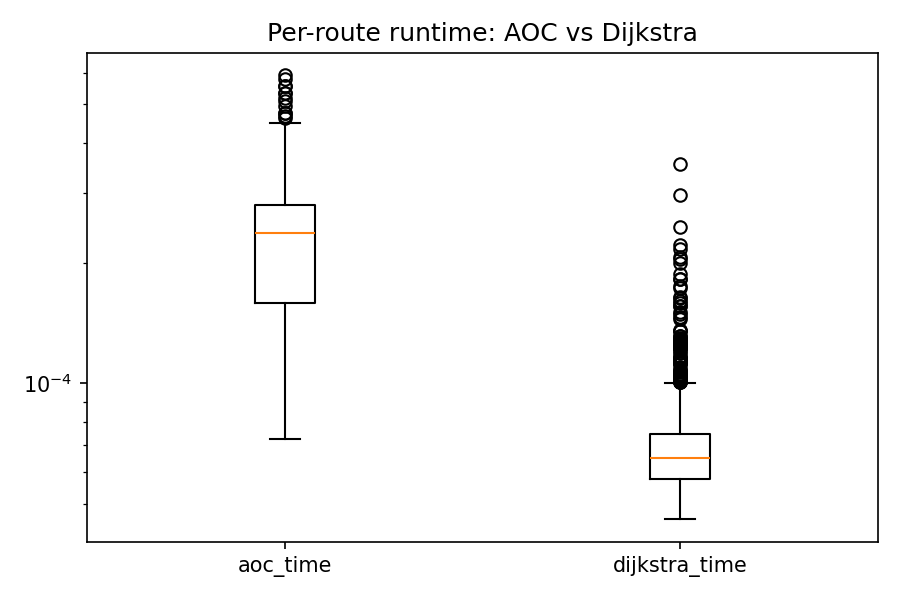

In [ ]:
#runtimes_box.png
display(Image(filename='outputs/analysis/plots/runtimes_box.png'))

**Per-route runtime: AOC vs Dijkstra**

The boxplot shows that the Ant Colony Optimization (AOC) method is both slower and far more variable in per-route runtime compared to Dijkstra. The median runtime for AOC is higher and the interquartile range is wide, indicating inconsistent performance across routes. In contrast, Dijkstra runs faster with a much tighter distribution and fewer extreme outliers, making it predictably efficient for single-source shortest-path calculations. For practical fleet routing, this suggests Dijkstra is preferable when low latency and consistency are required.

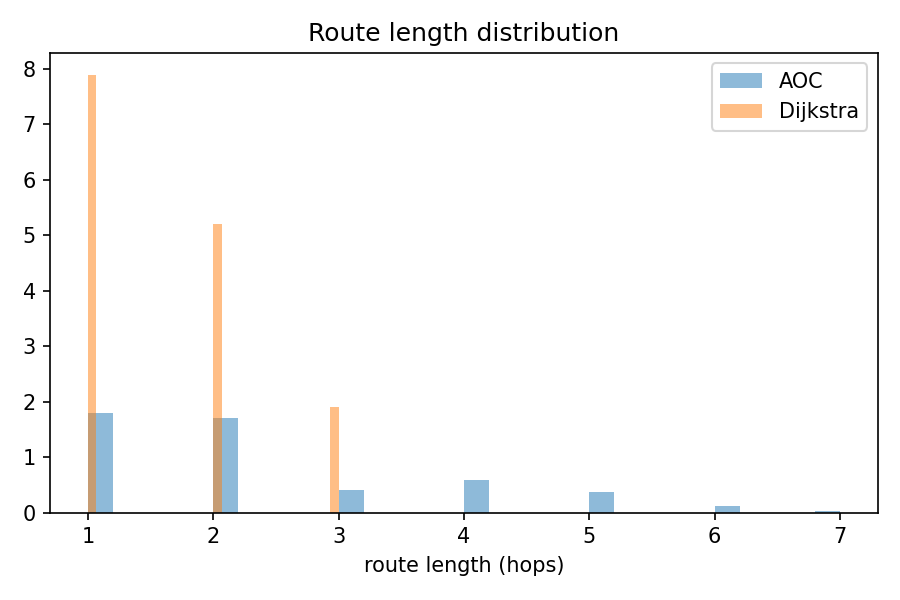

In [ ]:
#runtimes_box.png
display(Image(filename='outputs/analysis/plots/route_length_hist.png'))

**Route length distribution**

The histogram shows that routes found by Dijkstra are heavily concentrated at very short lengths (1–3 hops), whereas AOC produces a wider spread of route lengths extending up to 6–7 hops. This indicates that AOC explores longer alternative paths more often, while Dijkstra consistently finds the shortest-hop routes. The longer AOC routes may represent detours or exploratory solutions that could sometimes be beneficial (e.g., for avoiding congested links) but increase travel distance and time on average. For capacity planning and charging station placement, the dominance of short Dijkstra routes suggests most vehicles use nearby stations when shortest paths are prioritized.

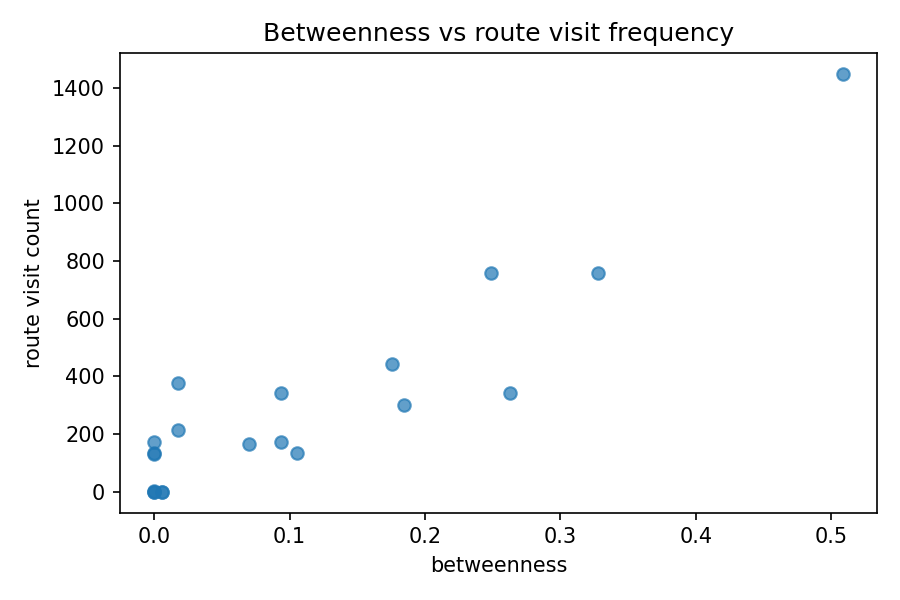

In [ ]:
#runtimes_box.png
display(Image(filename='outputs/analysis/plots/betweenness_vs_visits.png'))

**Betweenness vs. route visit frequency**

The scatter plot reveals a clear positive relationship: nodes with higher betweenness centrality tend to have higher route visit counts. This indicates that central corridors in the network concentrate routing activity and act as funnels for many vehicle trips. A few nodes have very high betweenness and correspondingly large visit counts, highlighting potential bottlenecks where congestion or overuse of charging infrastructure is most likely.

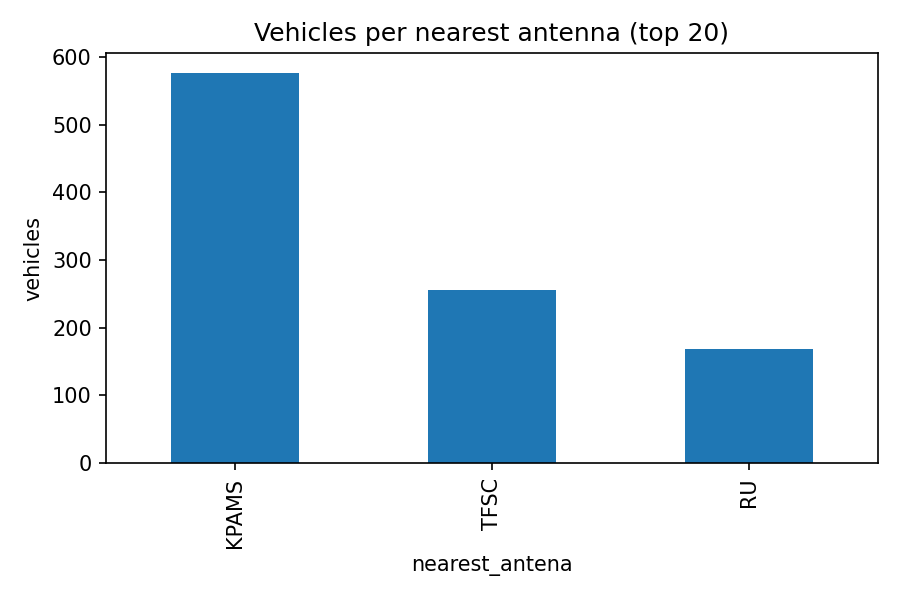

In [ ]:
#runtimes_box.png
display(Image(filename='outputs/analysis/plots/vehicles_per_antenna.png'))

**Vehicles per nearest antenna (top 20)**

The bar chart shows a pronounced imbalance in the number of vehicles assigned to antennas: a few antennas (e.g., the top bar) attract a large share of vehicles while many others receive far fewer. Such skewed demand implies that some stations will experience heavy load and may require capacity upgrades, while others could be underutilized. This distribution should inform targeted placement or scaling of charging infrastructure to better match demand and reduce wait times at the busiest antennas.

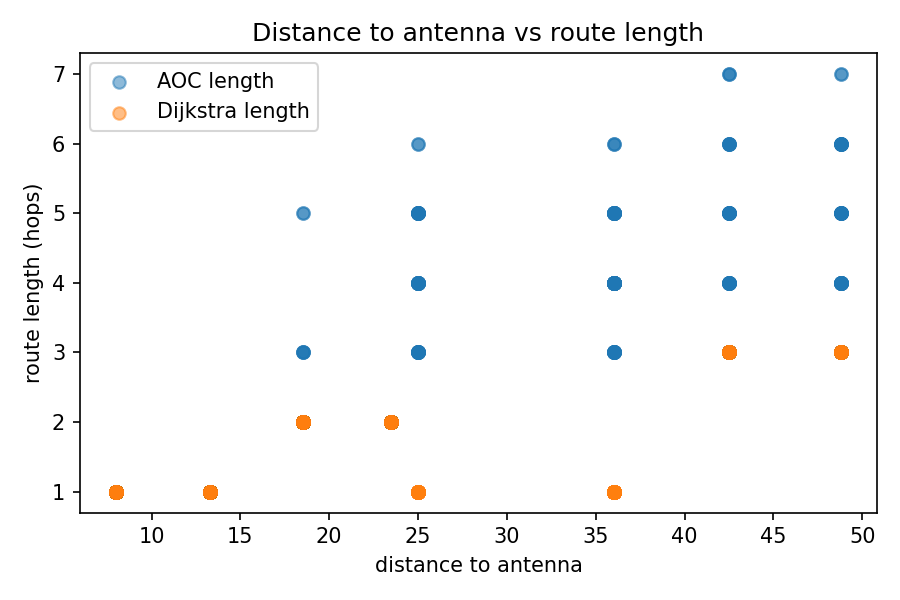

In [ ]:
#runtimes_box.png
display(Image(filename='outputs/analysis/plots/dist_to_antena_vs_length.png'))

**Distance to antenna vs. route length**

The scatter plot contrasts AOC and Dijkstra route lengths against the distance from a vehicle to its nearest antenna. Dijkstra route lengths remain compact and clustered at low hop counts, while AOC shows higher variance and more frequent longer routes as distance to the antenna increases. This suggests Dijkstra reliably picks minimal-hop paths to nearby stations, whereas AOC may favor alternative longer routes, especially when antennas are farther away. For routing policies that minimize travel effort to reach charging, Dijkstra-like shortest-path routing is more dependable.

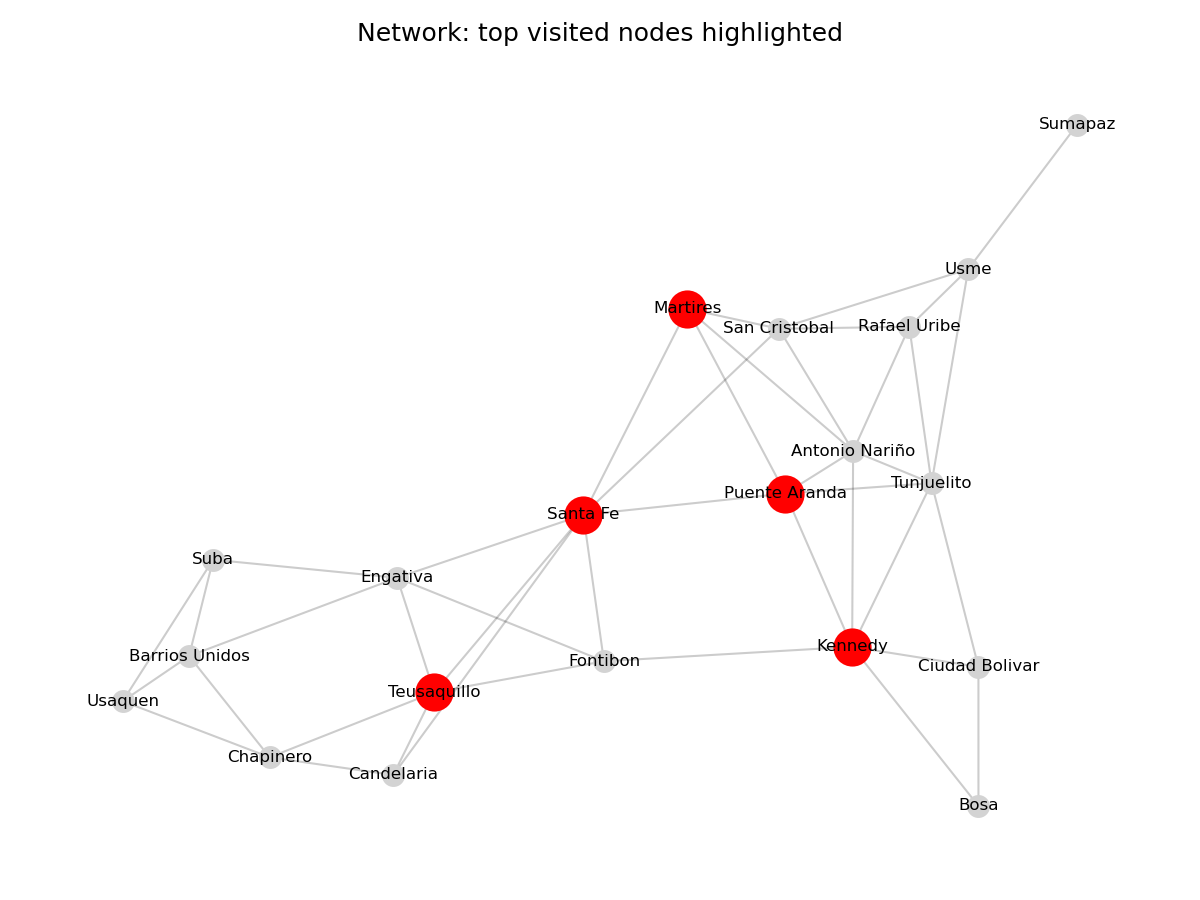

In [ ]:
#runtimes_box.png
display(Image(filename='outputs/analysis/plots/network_top_visits.png'))

**Network: top visited nodes highlighted**

The network overlay highlights the most frequently visited nodes (shown in red), which form a connected core across the city graph. These nodes (central neighborhoods) act as hubs for many routes and are likely to experience the highest traffic and charging demand. Removing or degrading any of these highlighted nodes would significantly affect connectivity and route options, so they are natural candidates for resiliency improvements and prioritized infrastructure investments.

---

# Conclusion

Dijkstra is faster and more predictable for per-route routing; AOC produces more diverse (often longer) alternatives. A small set of high‑betweenness nodes and a few antennas concentrate traffic and demand.

Limitations: the model uses a simplified network, lacks traffic/congestion dynamics, and AOC parameters are not exhaustively tuned — results are illustrative, not definitive.

Next steps: validate on a larger, realistic road network, add dynamic traffic and charging-queue models, tune AOC or test hybrid approaches, and run sensitivity analyses to guide infrastructure planning. In particular, evaluate an informed A* (A‑star) implementation with an admissible heuristic (e.g., straight-line or travel-time estimate to target antenna) as a goal-directed alternative — compare its speed and path quality against Dijkstra and AOC.


---

## References

Orús, A. (n.d.). Tesla: ingresos mundiales por segmento 2020-2021. Statista. Retrieved February 25, 2023, from https://es.statista.com/estadisticas/1271881/ingresos-de-tesla-por-segmento/

Forbes. (2022, September 29). Tesla: A history of innovation (and headaches). Forbes. Retrieved February 25, 2023, from https://www.forbes.com/sites/qai/2022/09/29/tesla-a-history-of-innovation-and-headaches/?sh=6460a1bf1873

Statista Research Department. (n.d.). Venta de vehículos eléctricos e híbridos en Colombia 2021. Statista. Retrieved February 26, 2023, from https://es.statista.com/estadisticas/1134824/volumen-ventas-vehiculos-electricos-hibridos-colombia/#statisticContainer

Verbel De Leon, A. (n.d.). Grafos dinámicos – Python. Mi Camino Master. Retrieved February 24, 2023, from http://micaminomaster.com.co/grafo-algoritmo/grafos-dinamicos-python/

Pourrahmani, H., et al. (2022). The applications of Internet of Things in the automotive industry: A review of the batteries, fuel cells, and engines. Internet of Things. https://doi.org/10.1016/j.iot.2022.100579

Lahby, M., & Sekkaki, A. (n.d.). A graph theory based network selection algorithm in heterogeneous wireless networks. IEEE. (Conference/journal details not provided)

Makeen, P., Memon, S., Elkasrawy, M. A., Abdullatif, S. O., & Ghali, H. A. (2022). Smart green charging scheme of centralized electric vehicle stations. International Journal of Green Energy, 19(5), 490–498. https://doi.org/10.1080/15435075.2021.1947822

Cadena Zárate, C. D., Caballero, J., Rojas Pérez, H. A., Solano, J., & Quiroga, O. A. (2022). Python-PowerFactory co-simulation for the optimal location of electric vehicle charging stations. International Journal of Ambient Energy, 43(1), 7541–7547. https://doi.org/10.1080/01430750.2022.2068060

Renaud-Blondeau, P., Boisjoly, G., Dagdougui, H., & He, S. Y. (2022). Powering the transition: Public charging stations and electric vehicle adoption in Montreal, Canada. International Journal of Sustainable Transportation. https://doi.org/10.1080/15568318.2022.2152403

Giménez-Gaydou, D. A., Ribeiro, A. S. N., Gutiérrez, J., & Antunes, A. P. (2016). Optimal location of battery electric vehicle charging stations in urban areas: A new approach. International Journal of Sustainable Transportation, 10(5), 393–405. https://doi.org/10.1080/15568318.2014.961620
